In [8]:
import timeit
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import os
from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Clean and tokenize text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('stopwords') # download stopwords corpus
nltk.download('punkt') # download punkt tokenizer

# For linear regression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Hannah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set directory

In [9]:
%cd /Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline

/Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


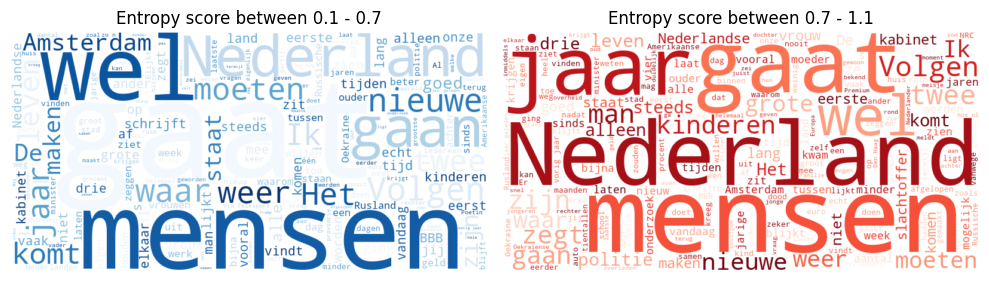

             shares           wow         cares           sad         angry   
count  10550.000000  10550.000000  10550.000000  10550.000000  10550.000000  \
mean      13.964171     10.801327     15.809005     12.930521     11.451280   
std       52.208274     54.790098     75.728753     65.743179     58.293095   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        2.000000      0.000000      0.000000      0.000000      0.000000   
75%        9.000000      0.000000      0.000000      0.000000      0.000000   
max     1600.000000    918.000000    999.000000    945.000000    990.000000   

               haha  reactions_count      comments          like   
count  10550.000000     10550.000000  10550.000000  10550.000000  \
mean      29.078294       174.680474    167.404076     94.610047   
std       82.204197       282.039923    391.106855    176.895798   
min        0.000

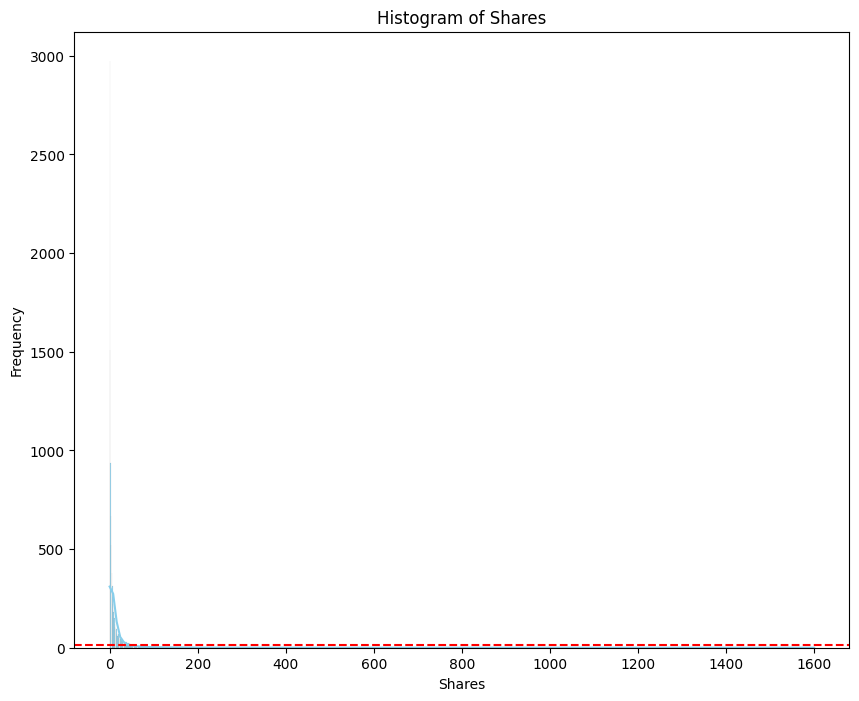

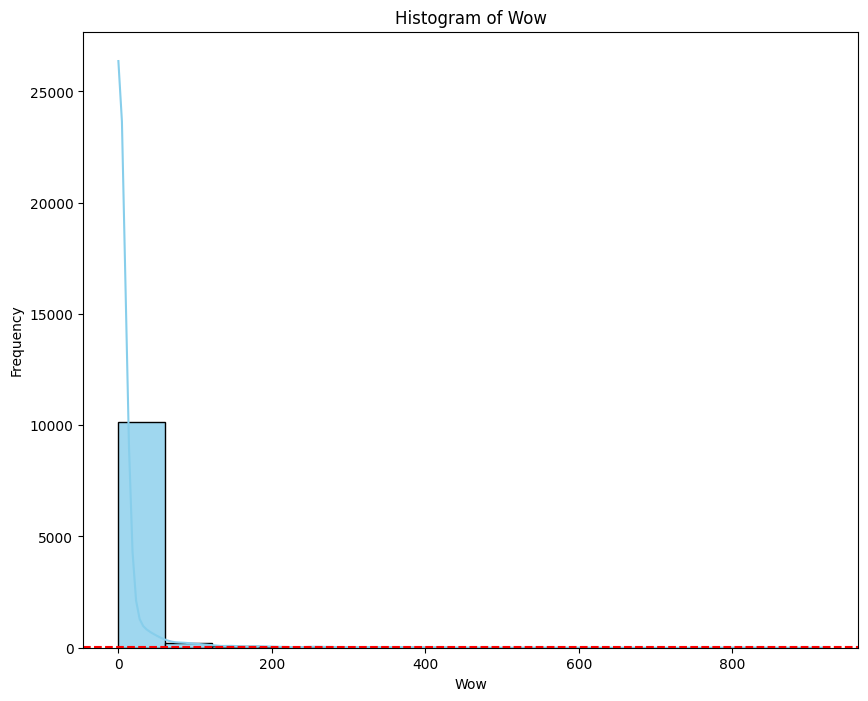

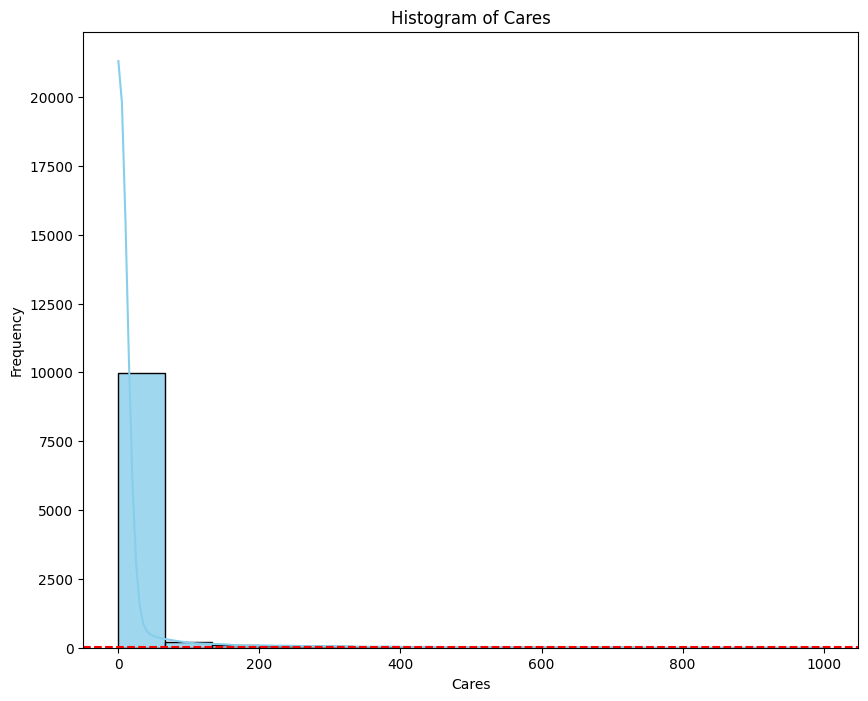

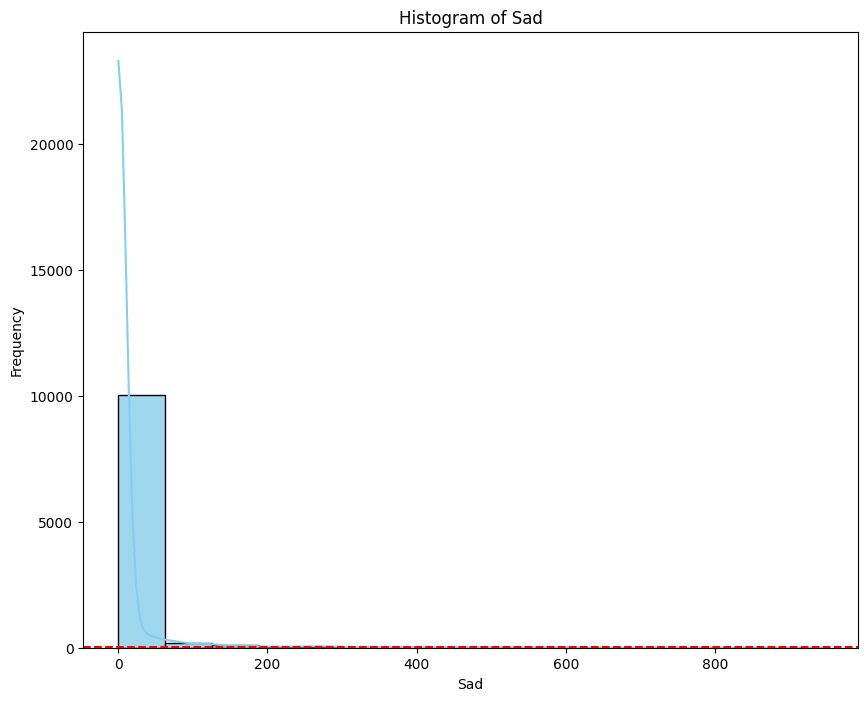

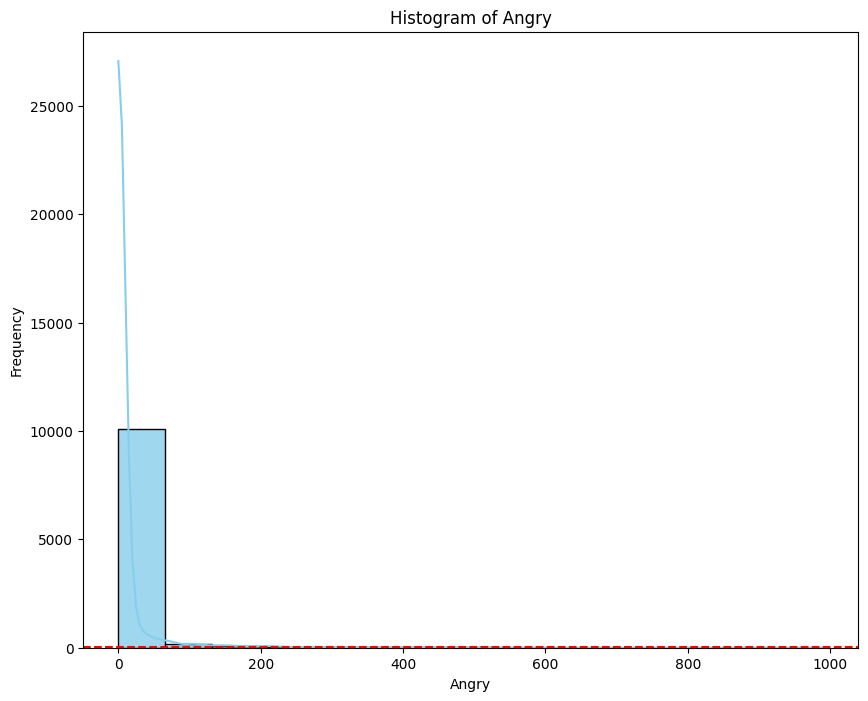

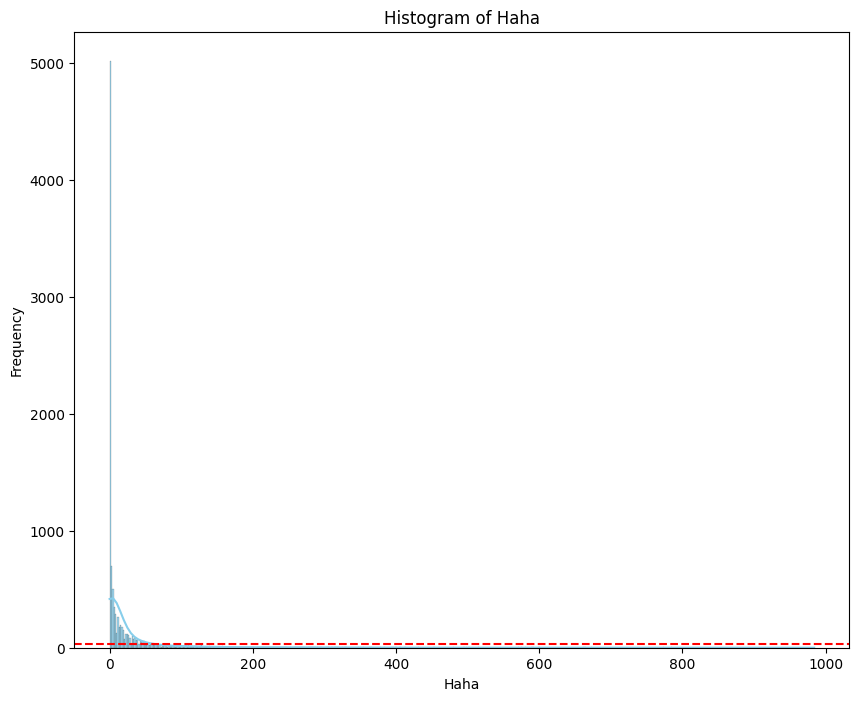

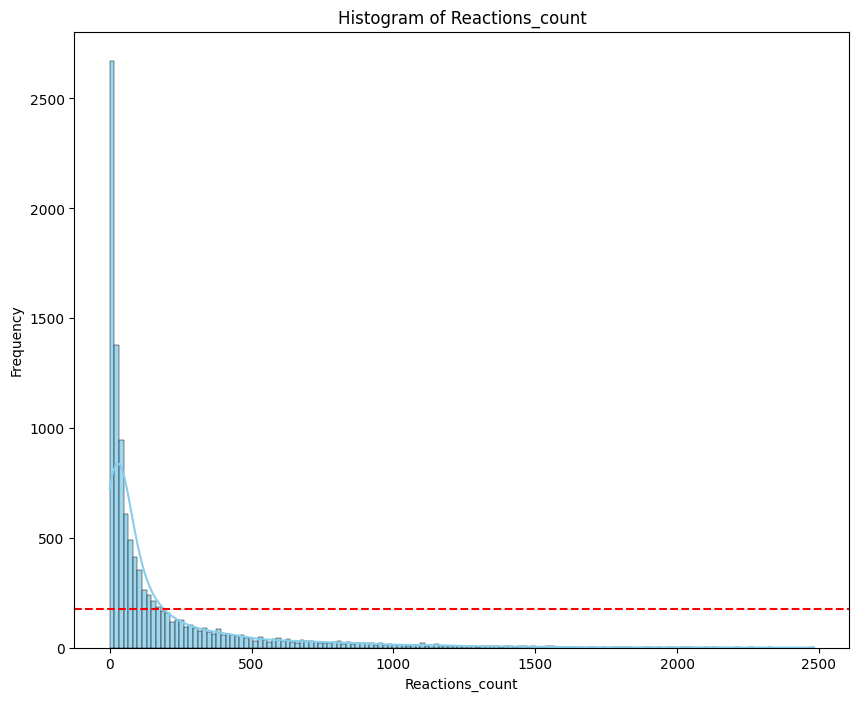

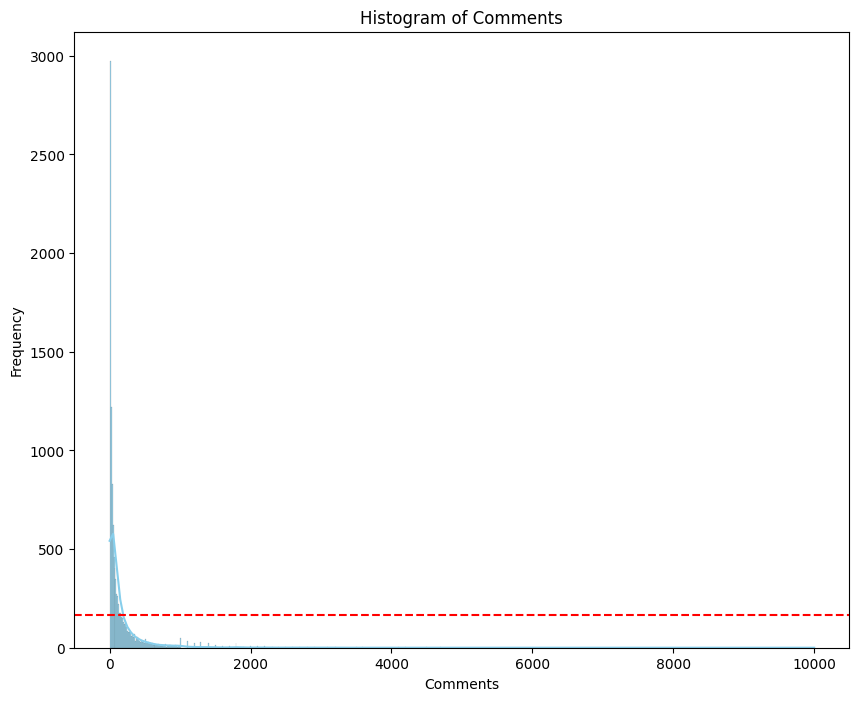

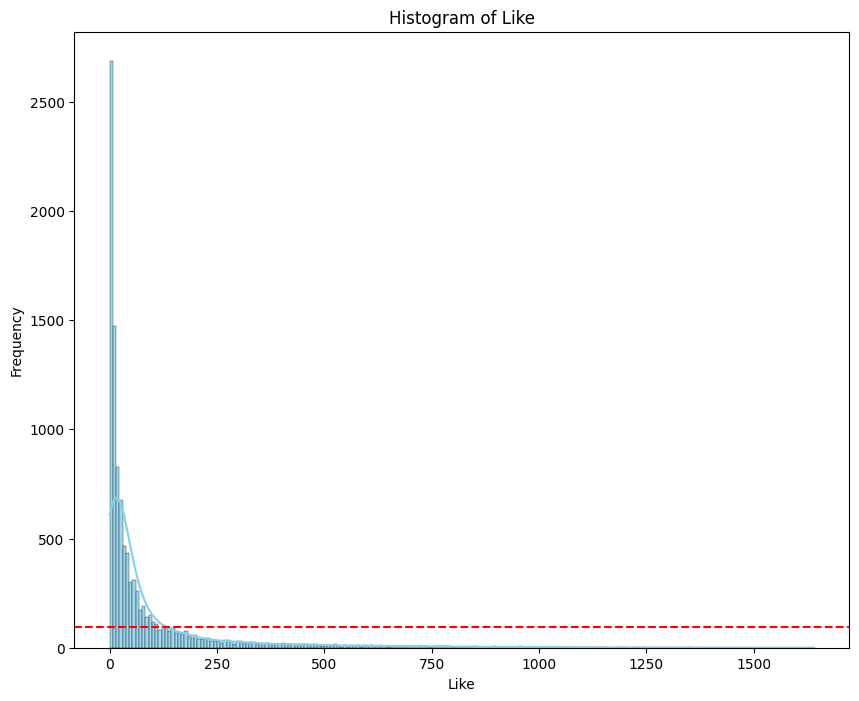

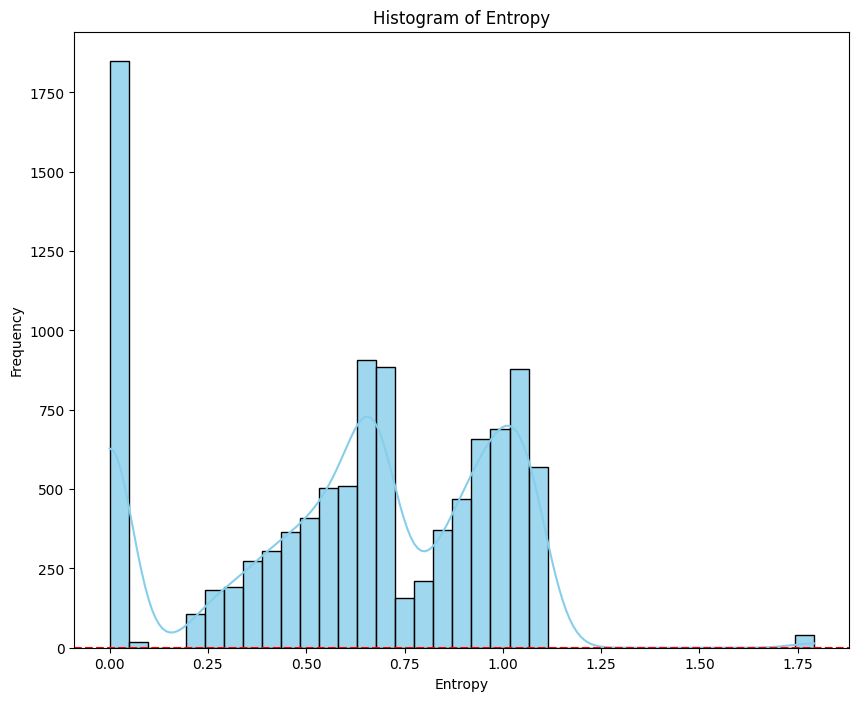

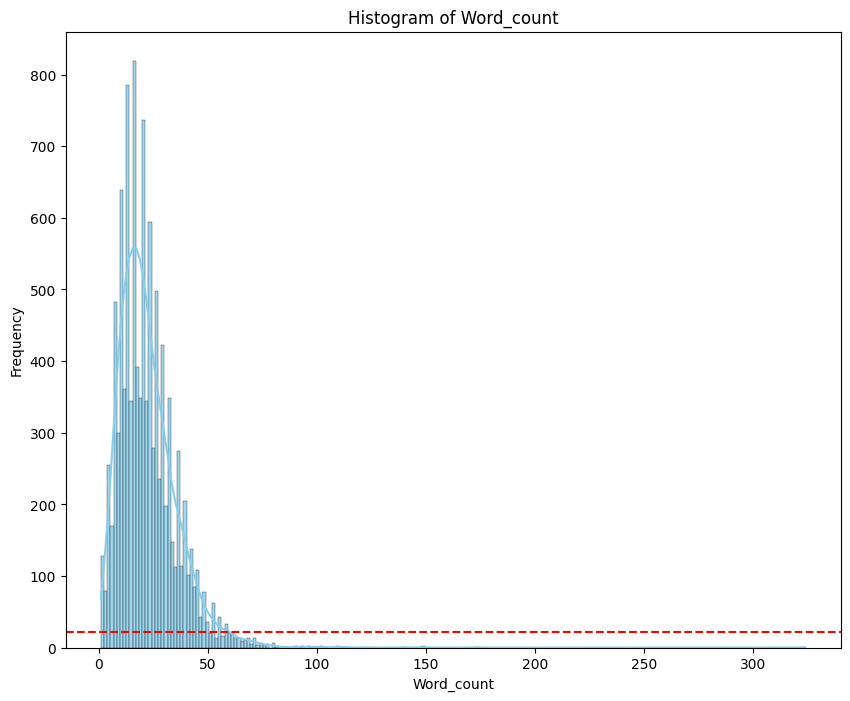

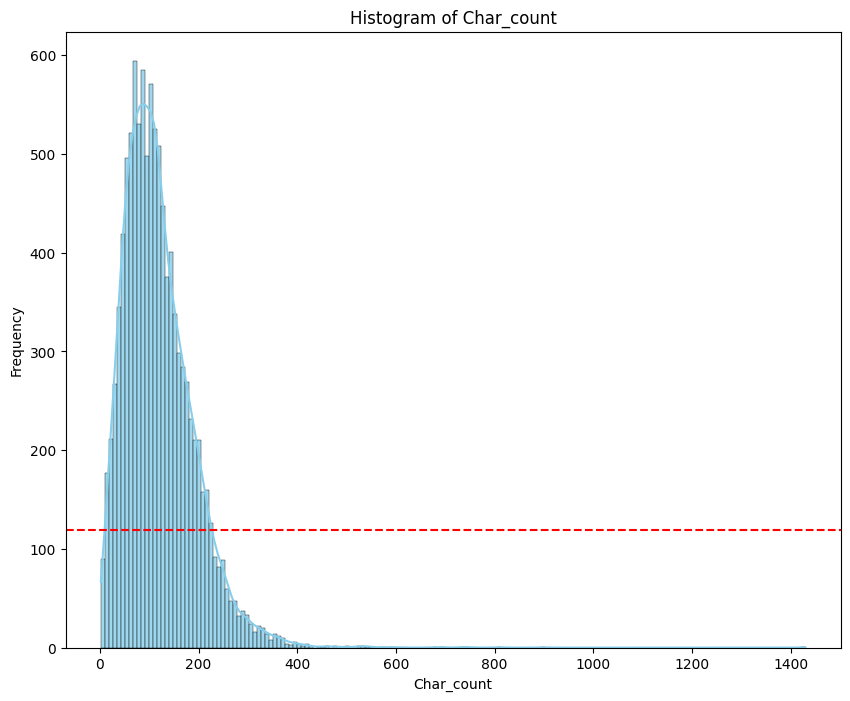

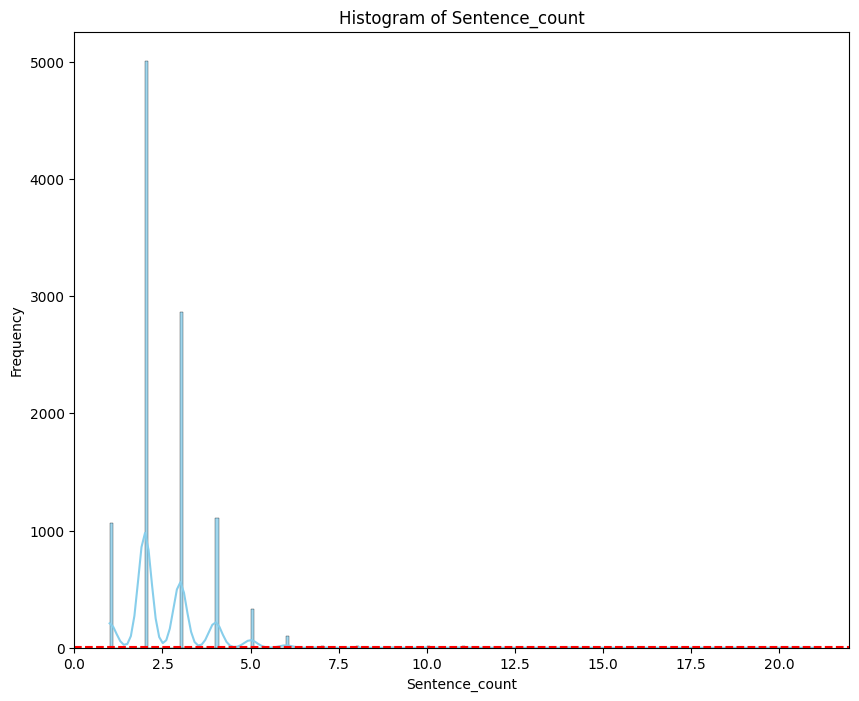

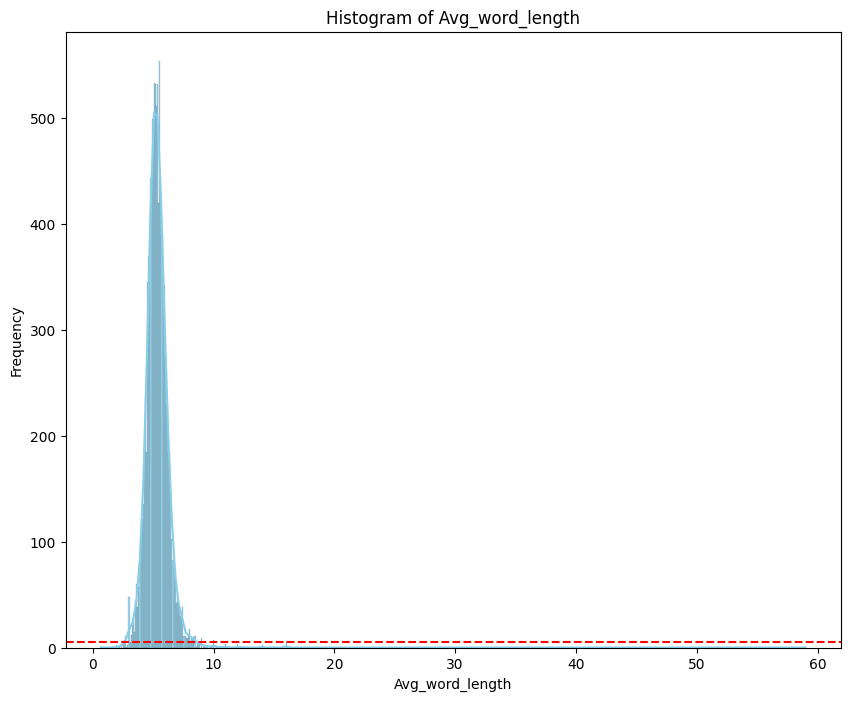

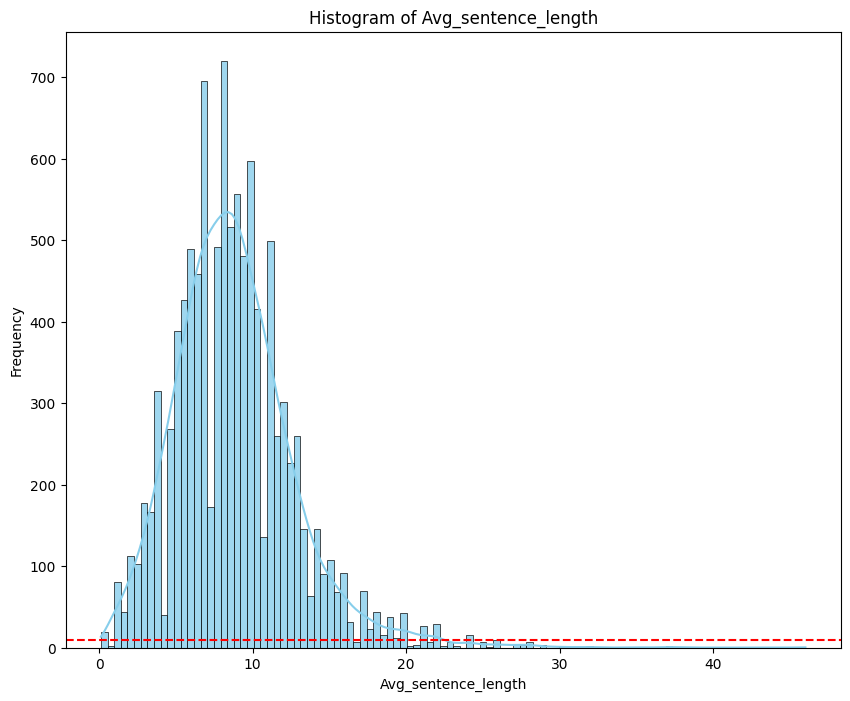

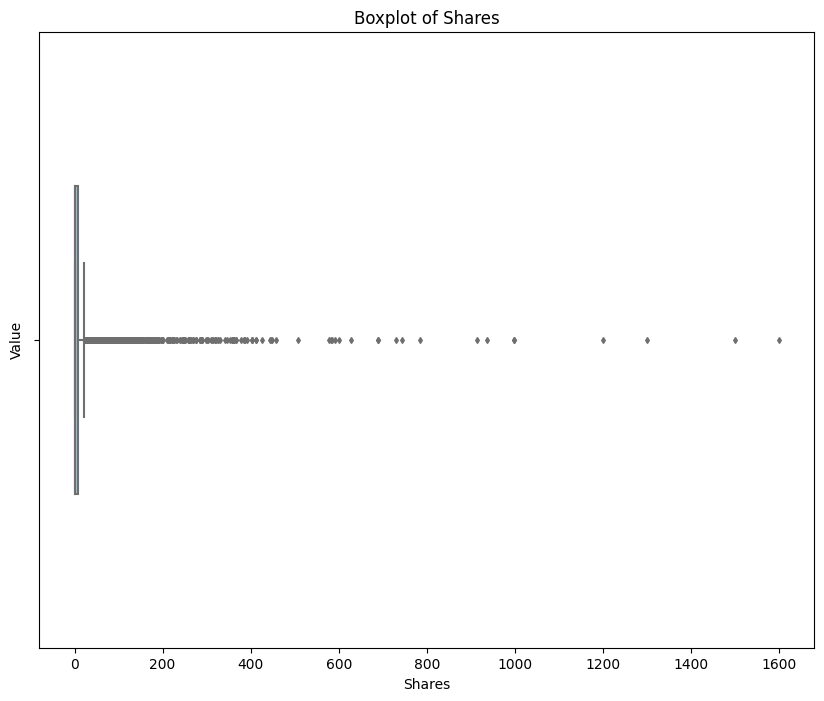

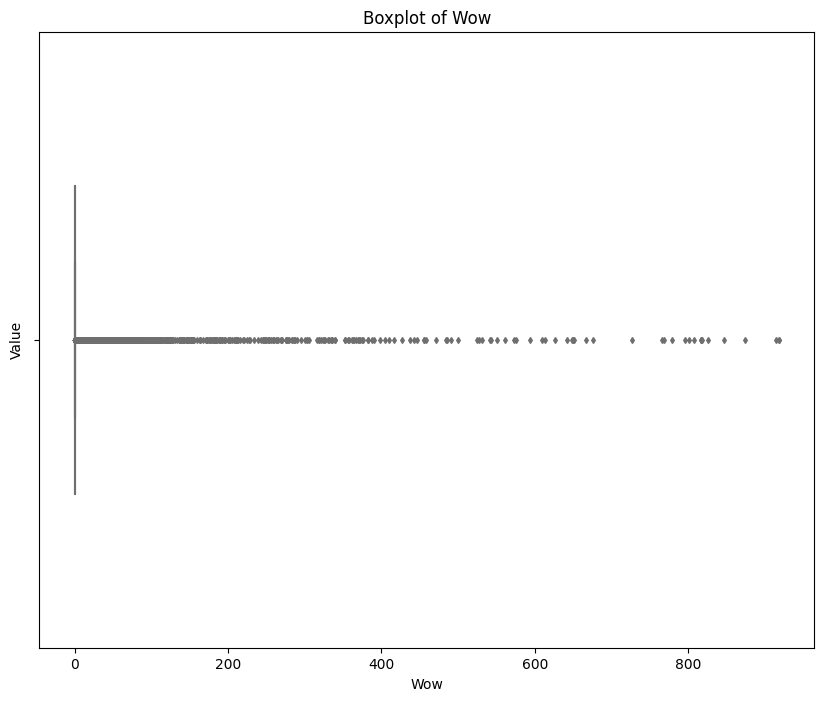

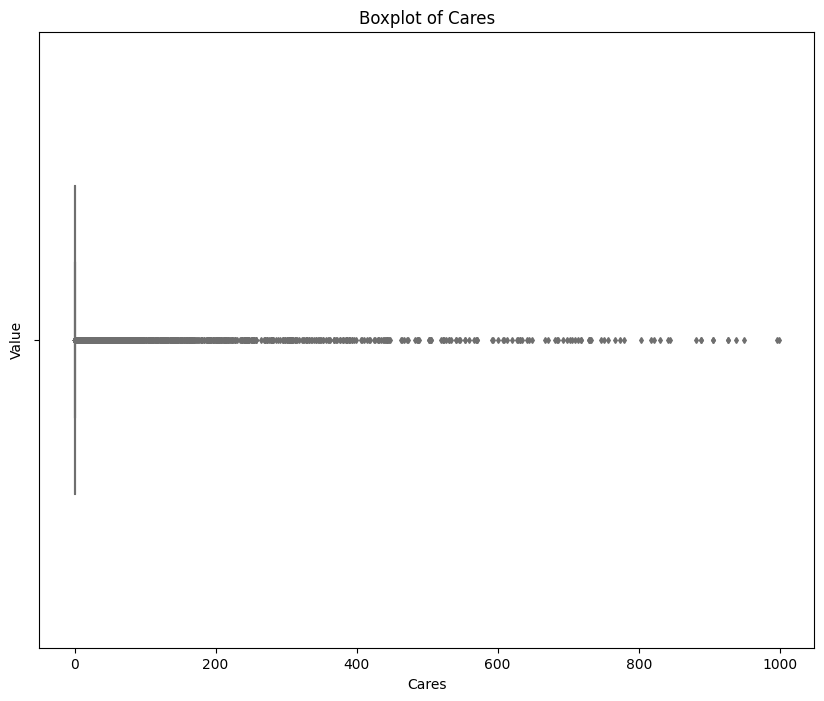

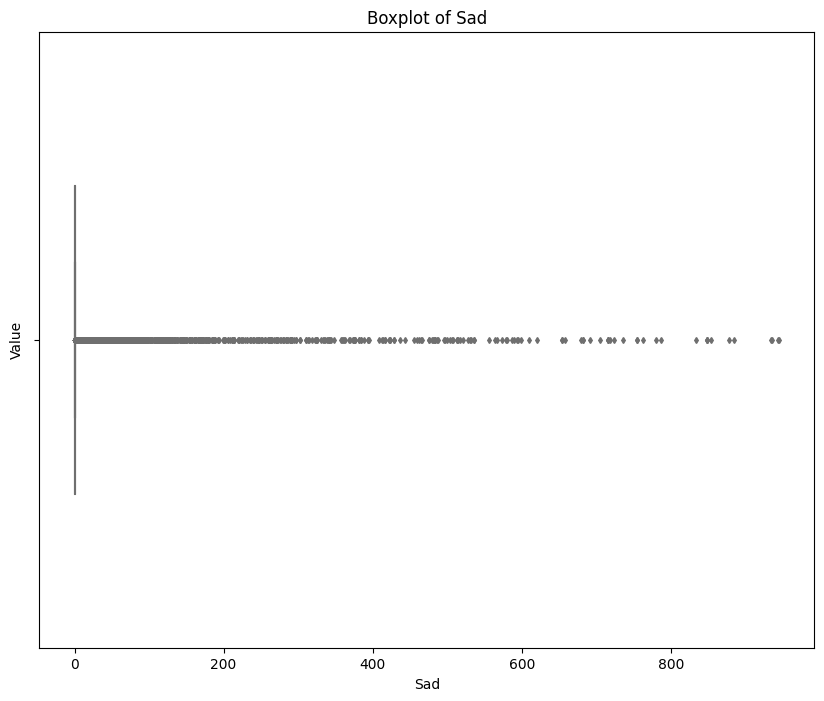

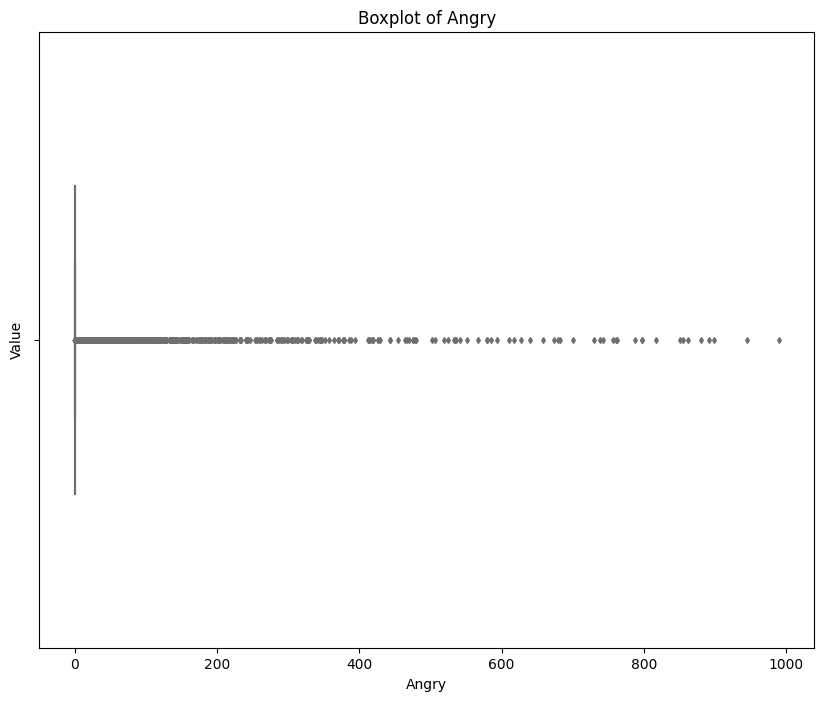

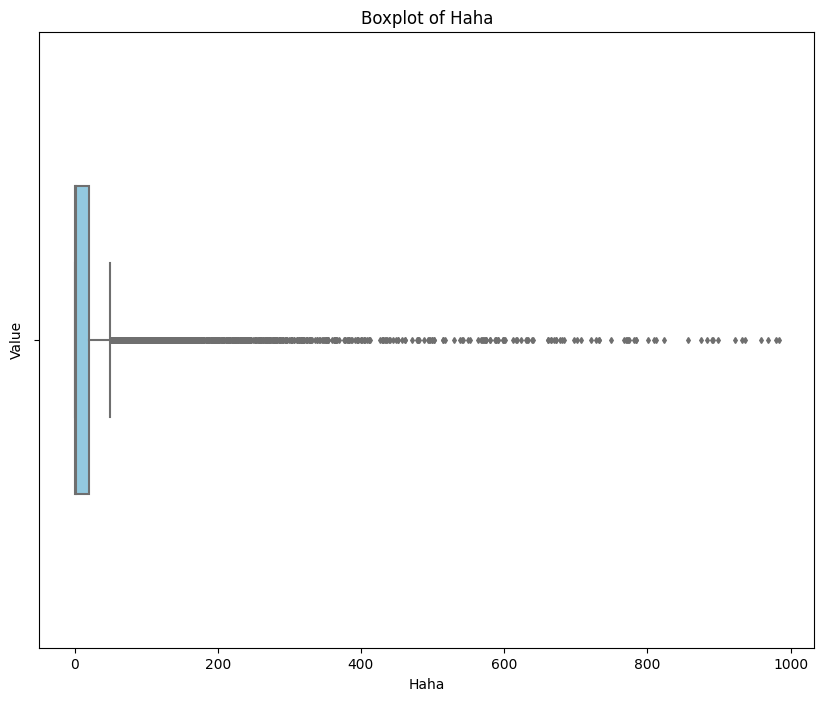

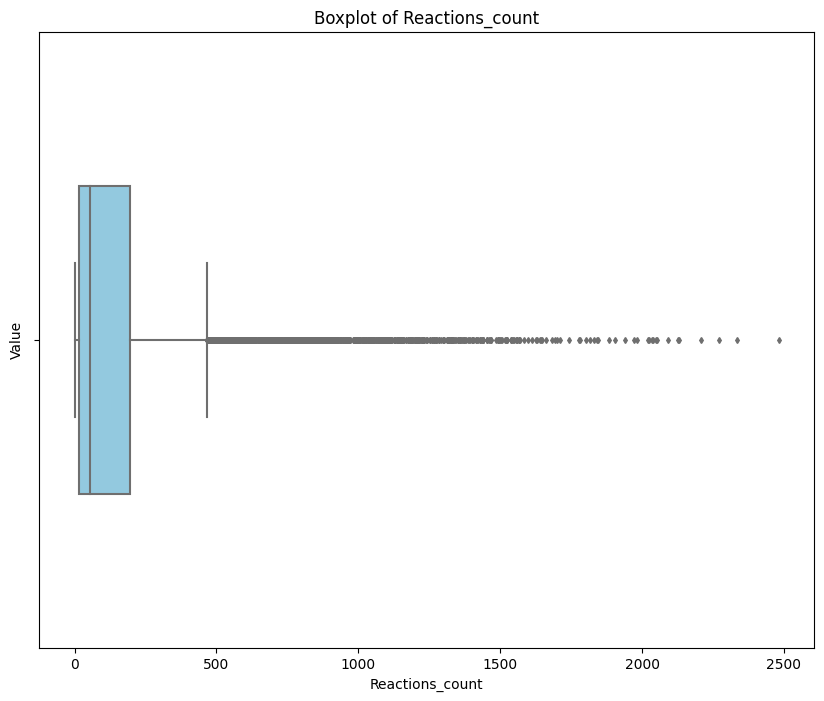

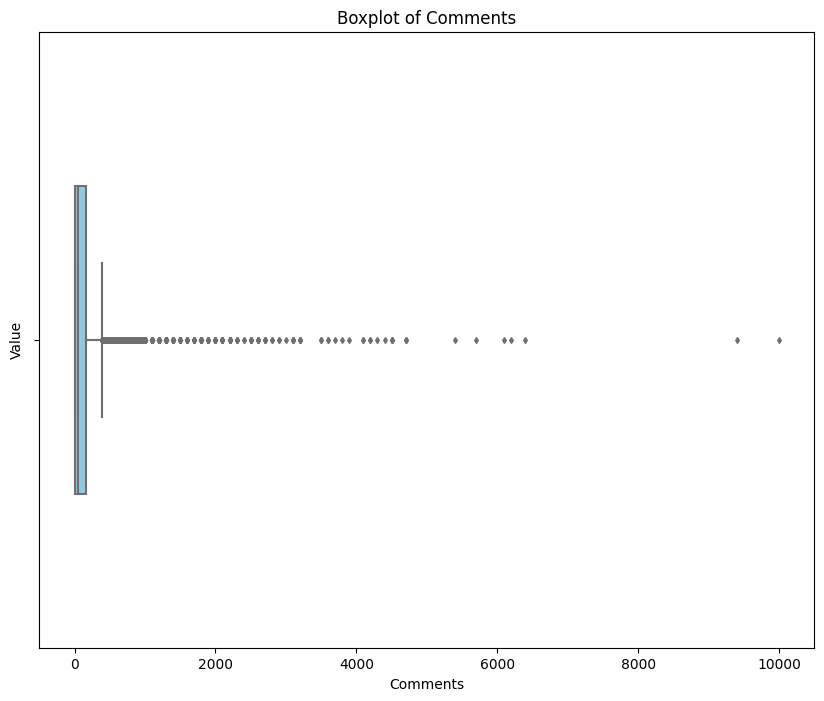

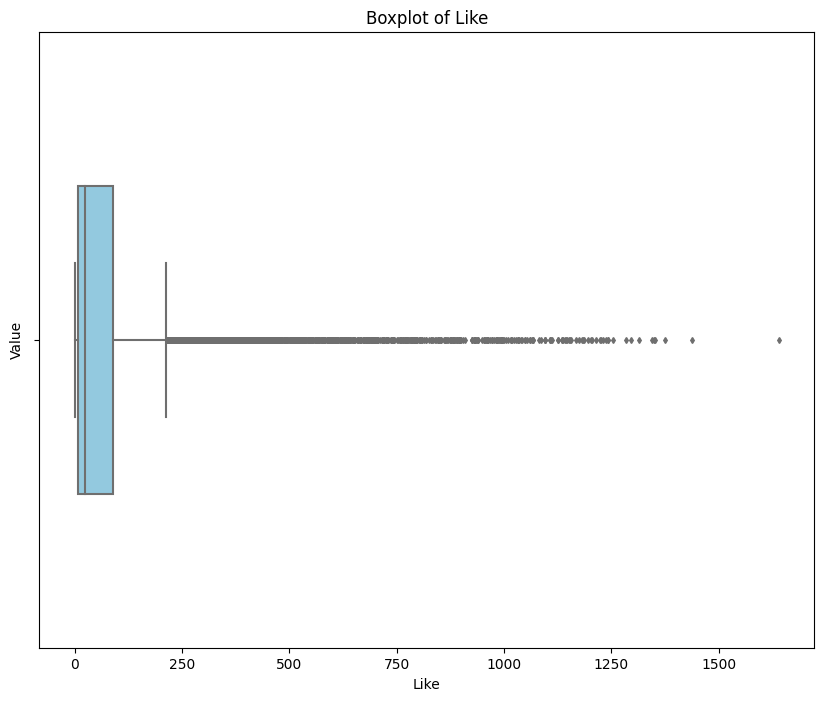

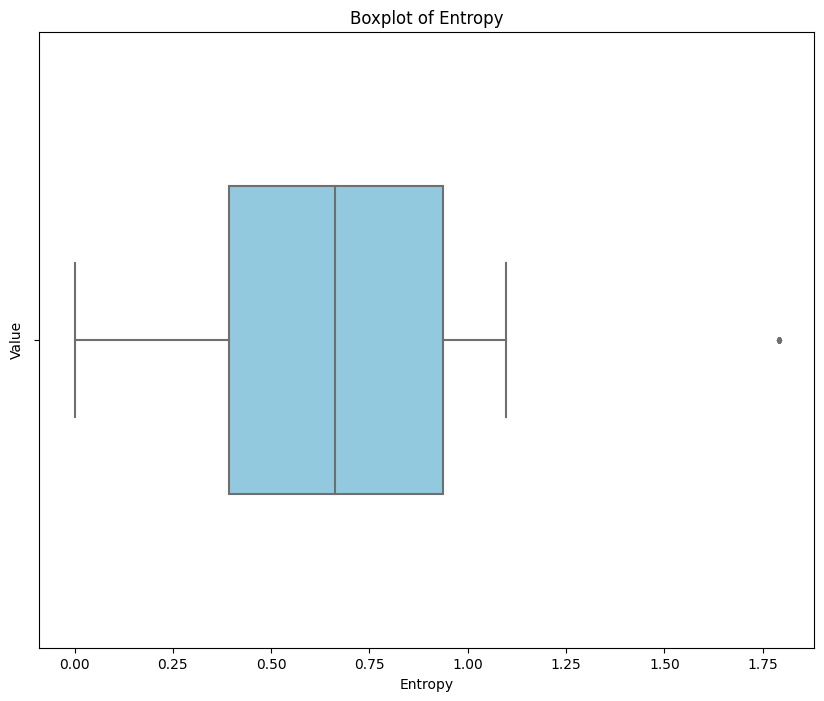

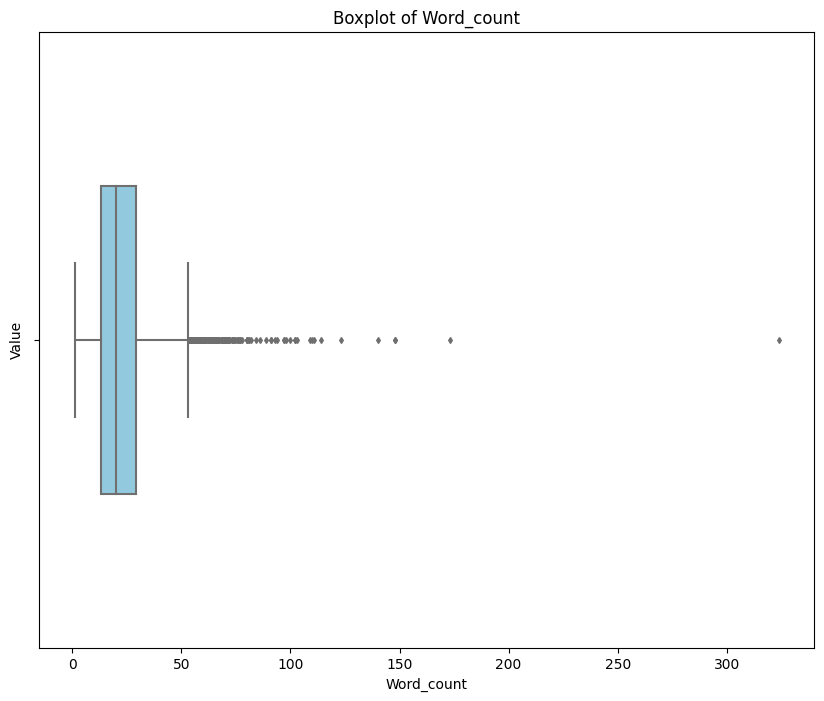

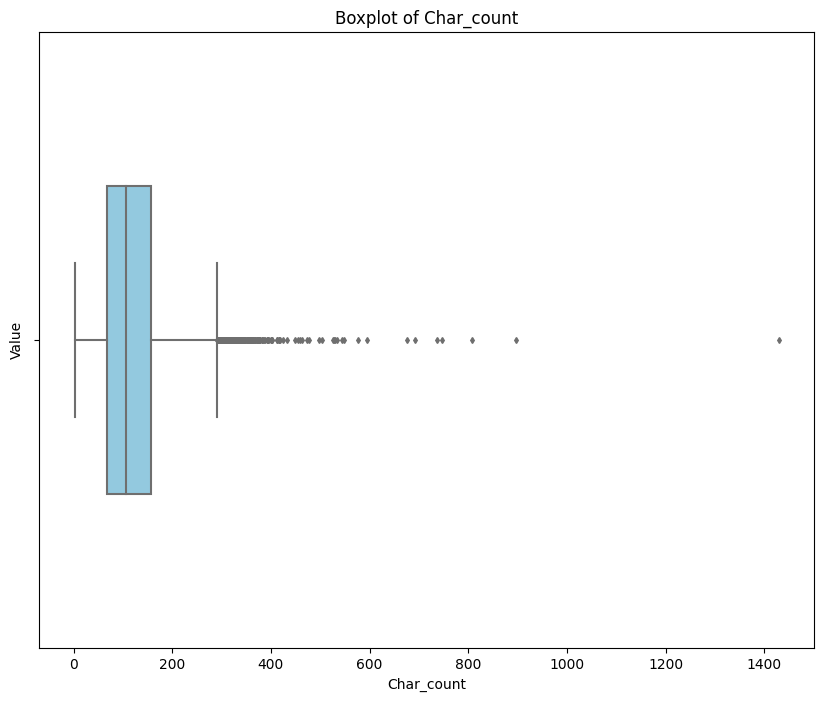

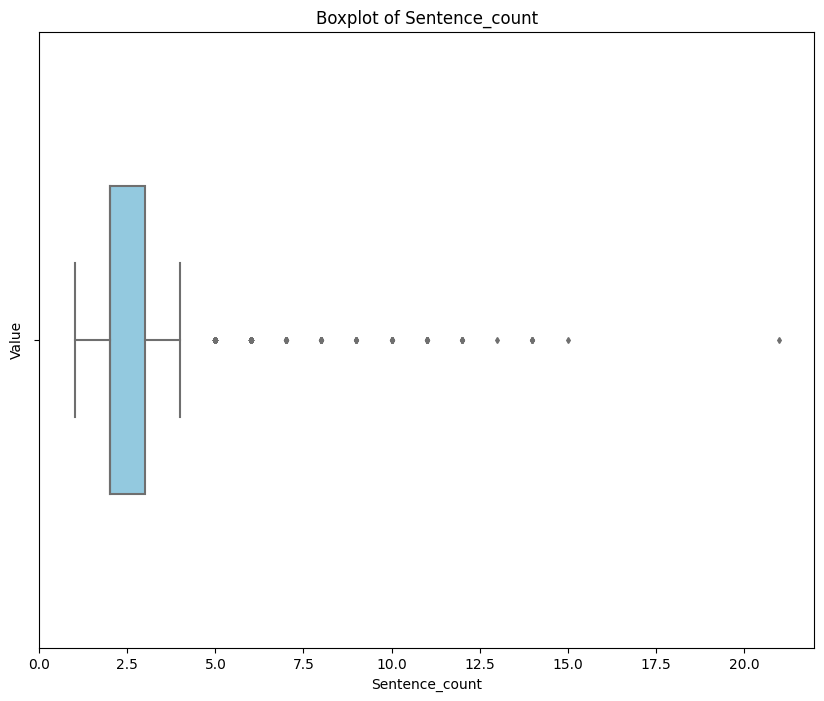

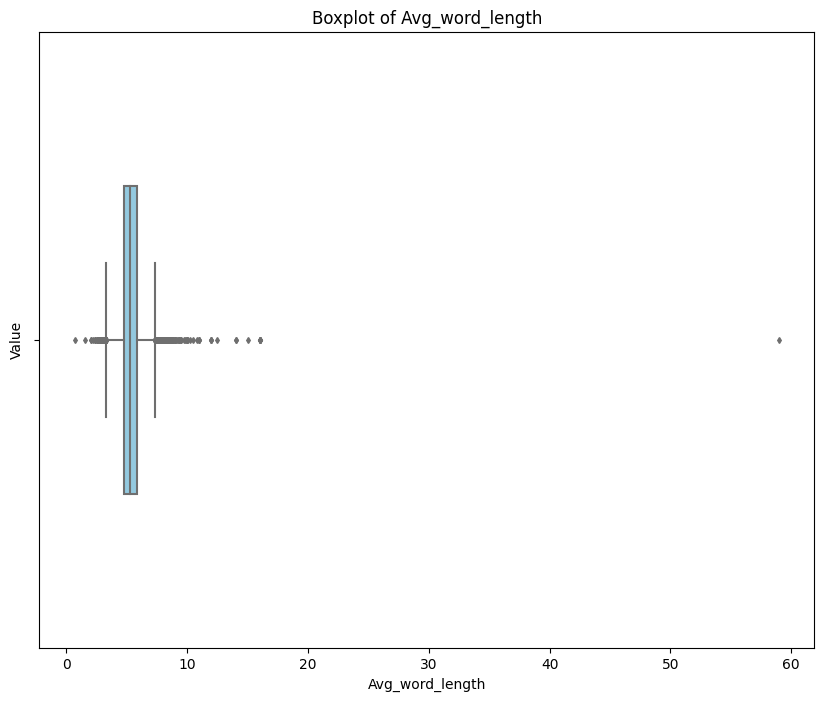

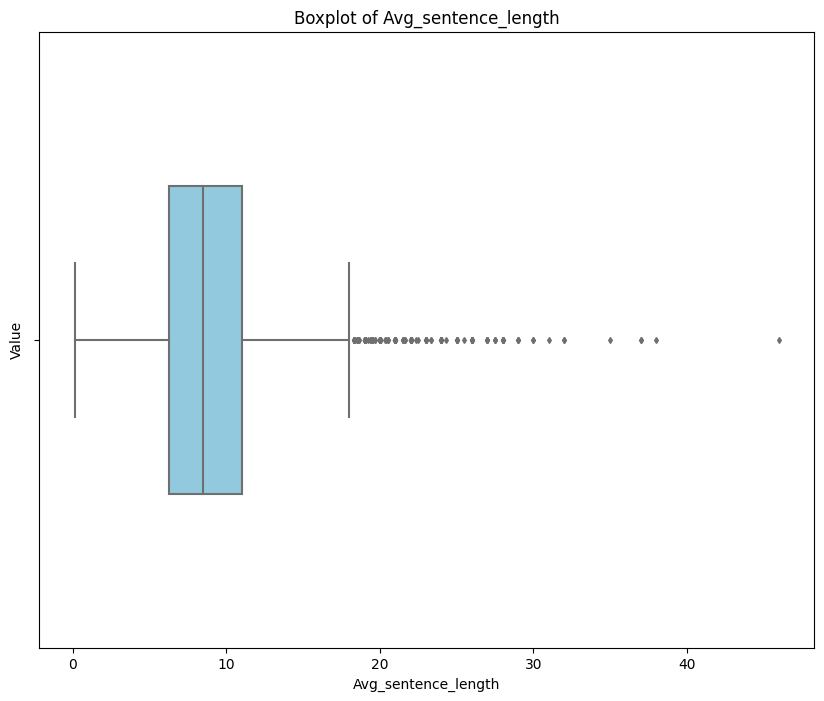

Texts of news posts with highest entropy:
1.791759469228055 Kohlstedt neemt zijn publiek mee in zijn muzikale leefwereld. Hij begon wat met de toetsen te pielen op het ritme van een grote, zwaar tikkende klok. En zo, zegt hij, is hij eigenlijk altijd blijven improviseren.

1.791759469228055 Nederland heeft drie verdachten van aanslagen in het drugsmilieu in en rond Antwerpen overgedragen aan België, waaronder een man uit Amsterdam. Een van de drie twintigers was mogelijk een opdrachtgever.

1.791759469228055 Henk Veldmate keert na zeven jaar terug bij FC Groningen.

1.791759469228055 Een telefoon is er tegenwoordig niet alleen maar voor de leuk, stellen sommigen, maar óók voor werk, GPS en contact met bijvoorbeeld de overheid.

1.791759469228055 Willen we meer of minder groenbescherming? Een Amsterdams referendum is na het behalen van de benodigde 10.000 steunhandtekeningen een stap dichterbij.

Texts of news posts with lowest entropy:
9.274627192749207e-10 Heel goed nieuws voor de fam

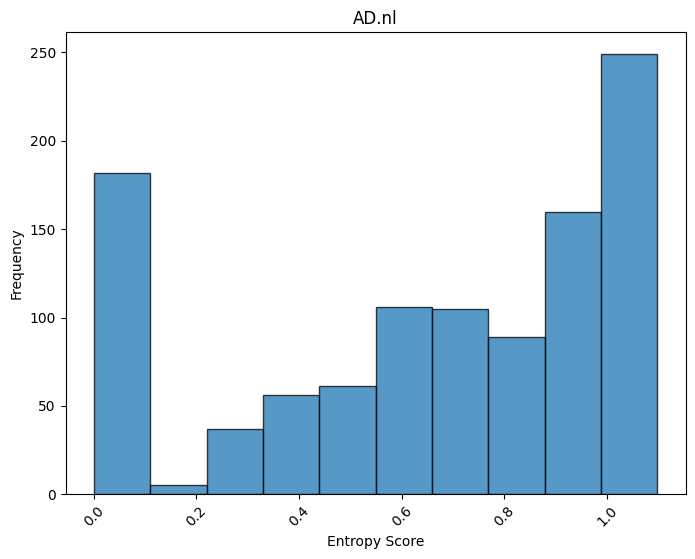

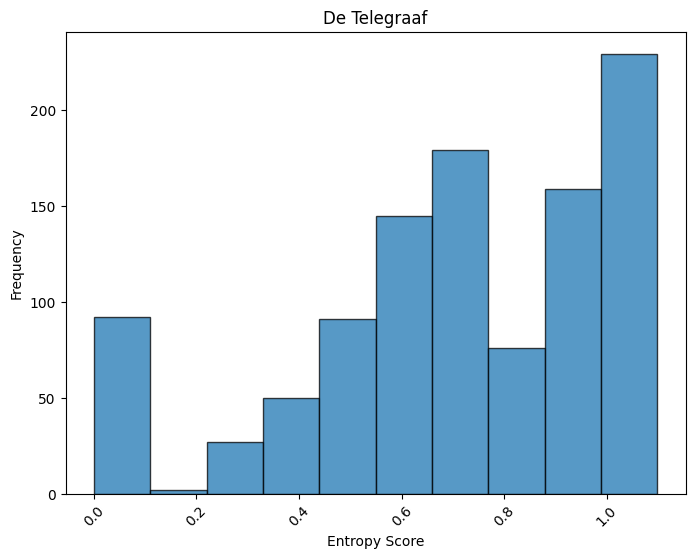

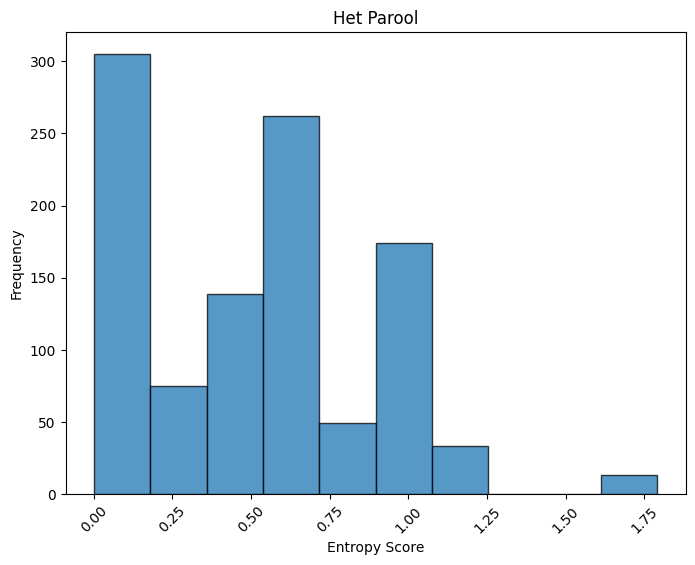

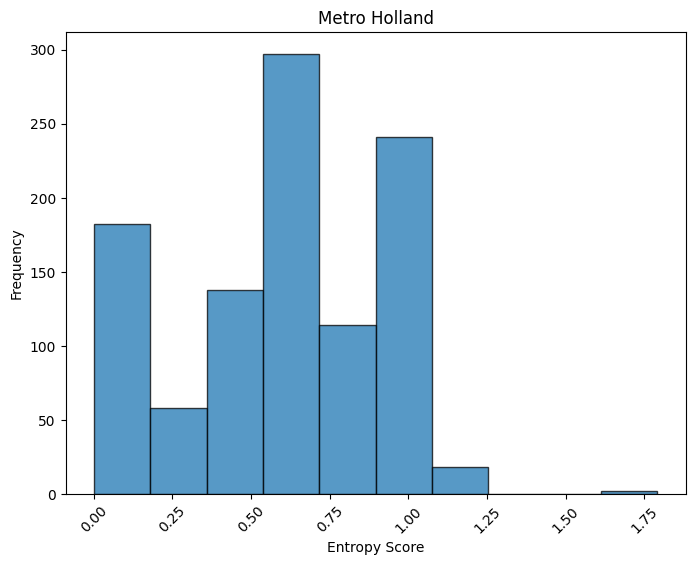

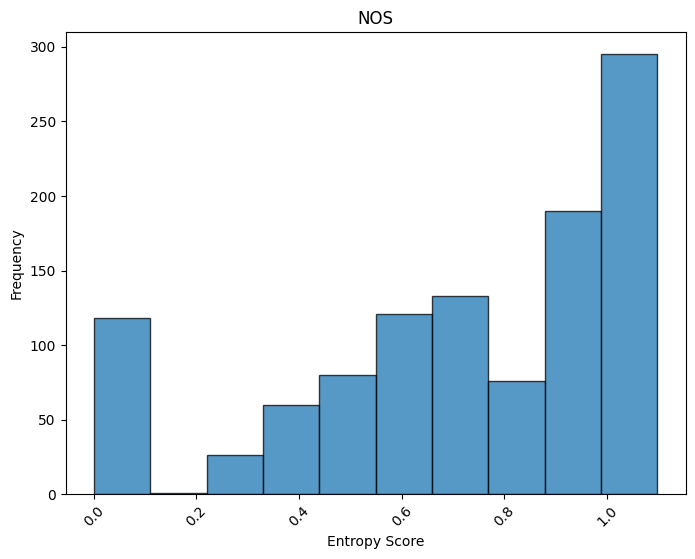

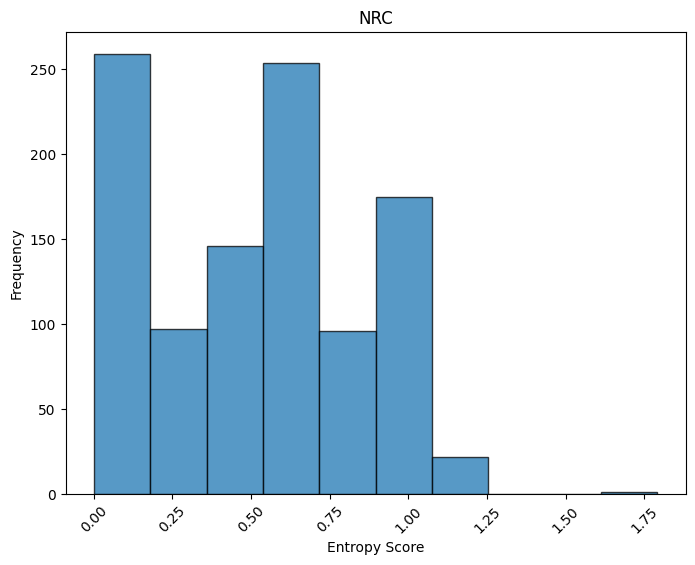

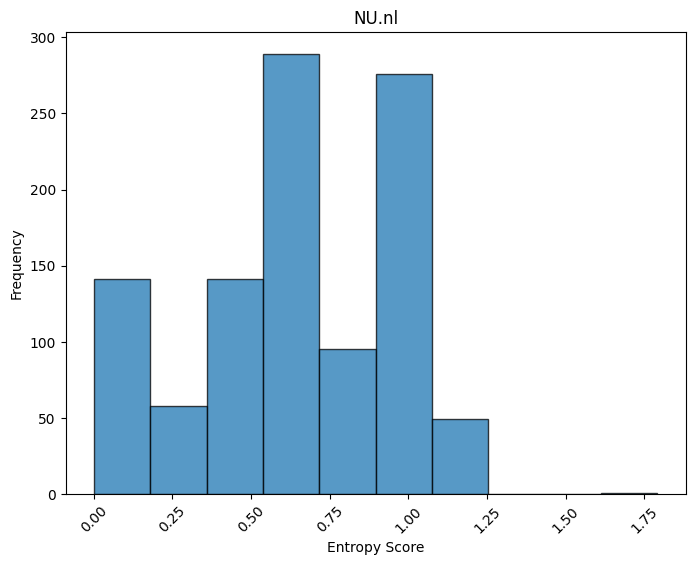

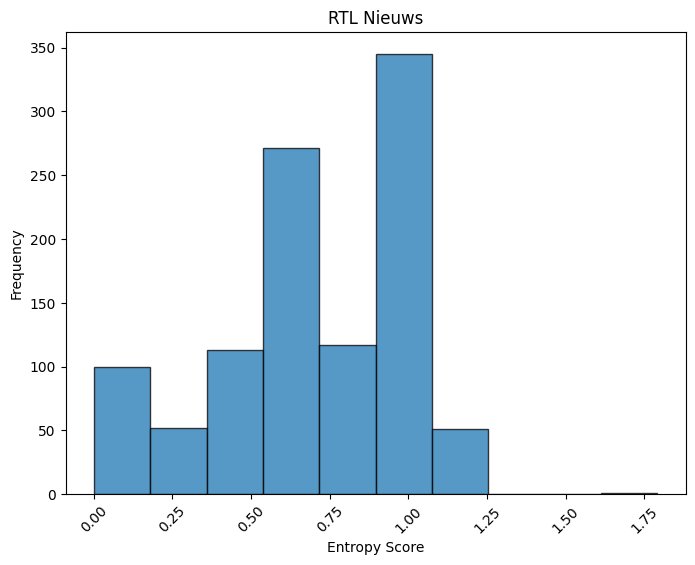

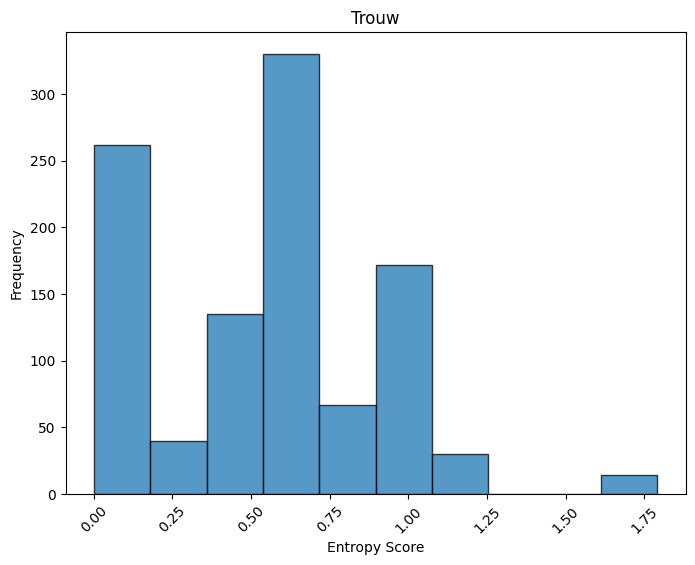

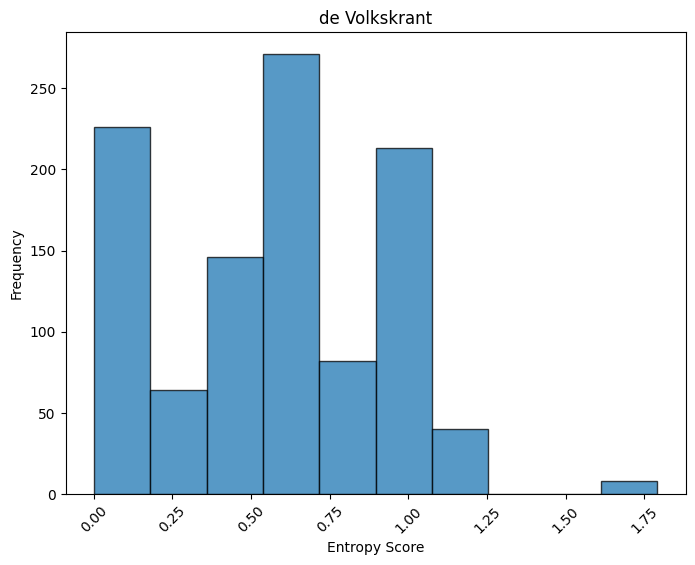

Reaction Distribution per News Source:
                 like    wow  cares    sad  angry   haha   total
name                                                            
AD.nl          170066  22532  34948  29662  26536  44652  328396
De Telegraaf    91567  13624  18485  14732  13905  39055  191368
Het Parool      25573    948   3218   2704    990   3385   36818
Metro Holland   76100   6762   9878   5964   7796  27038  133538
NOS            222056  31667  36204  32094  32239  78104  432364
NRC             88025   2094   8044   4345   1367  16441  120316
NU.nl          125169   9588  15743  10886   9500  34280  205166
RTL Nieuws     142798  25029  31340  30296  25159  51461  306083
Trouw           10792    312   1964   1295    882   3612   18857
de Volkskrant   45990   1398   6961   4439   2437   8748   69973

Total Likes: 998136
Total Wows: 113954
Total Cares: 166785
Total Sads: 136417
Total Angrys: 120811
Total Hahas: 306776

Total Reactions:
like      998136
wow       113954
cares    

In [12]:
# Define the reaction columns and total reactions column name
reaction_columns = ["like", "wow", "cares", "sad", "angry", "haha"]
total_reactions = "reactions_count"

class EntropyCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, reaction_columns, total_reactions):
        self.reaction_columns = reaction_columns
        self.total_reactions = total_reactions
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a copy of the input DataFrame
        X_transformed = X.copy()
        
        # Define a function to calculate the entropy
        def calculate_entropy(row):
            # Get the reaction counts for the row
            counts = row[self.reaction_columns].values
            # Normalize the counts to probabilities
            eps = 1e-8  # a very small positive number
            probabilities = (counts.astype(float) + eps) / (row[self.total_reactions] + len(self.reaction_columns) * eps)
            
            # Calculate the entropy
            return entropy(probabilities)
        
        # Apply the entropy calculation function to each row
        X_transformed["entropy"] = X_transformed.apply(calculate_entropy, axis=1)
        
        return X_transformed


# Custom transformer for descriptive statistics
class DescriptiveStatistics(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(X.describe())
        return X

# Custom transformer for plotting descriptive statistics
class DescriptiveStatsPlotter(BaseEstimator, TransformerMixin):
    def __init__(self, figsize=(10, 8)):
        self.figsize = figsize
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Calculate descriptive statistics
        desc_stats = X.describe()
        
        # Plot histogram for each numerical column
        for col in desc_stats.columns:
            if pd.api.types.is_numeric_dtype(X[col]):
                fig, ax = plt.subplots(figsize=self.figsize)
                sns.histplot(data=X, x=col, kde=True, color="skyblue", alpha=0.8)
                average = X[col].mean()
        
                # Add the average line
                ax.axhline(average, color='red', linestyle='--', label='Average')
                ax.set_xlabel(col.capitalize())
                ax.set_ylabel("Frequency")
                ax.set_title(f"Histogram of {col.capitalize()}")
                plt.show()
        
        # Plot boxplot for each numerical column
        for col in desc_stats.columns:
            if pd.api.types.is_numeric_dtype(X[col]):
                fig, ax = plt.subplots(figsize=self.figsize)
                sns.boxplot(data=X, x=col, color="skyblue", width=0.5, fliersize=3)
                ax.set_xlabel(col.capitalize())
                ax.set_ylabel("Value")
                ax.set_title(f"Boxplot of {col.capitalize()}")
                plt.show()
        
        # Plot countplot for each categorical column
        for col in desc_stats.columns:
            if pd.api.types.is_categorical_dtype(X[col]):
                fig, ax = plt.subplots(figsize=self.figsize)
                sns.countplot(data=X, x=col, color="skyblue")
                ax.set_xlabel(col.capitalize())
                ax.set_ylabel("Count")
                ax.set_title(f"Countplot of {col.capitalize()}")
                plt.show()
        
        return X
    
# Transformer for length analysis
class LengthAnalysisTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['word_count'] = X["content"].apply(lambda x: len(str(x).split(" ")))
        X['char_count'] = X["content"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
        X['sentence_count'] = X["content"].apply(lambda x: len(str(x).split(".")))
        X['avg_word_length'] = X['char_count'] / X['word_count']
        X['avg_sentence_length'] = X['word_count'] / X['sentence_count']
        return X

class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop rows with entropy score of 1.3 and higher
        X = X[X['entropy'] < 1.3]
        
        # Delete rows with total reactions count of 30 and lower
        X = X[X['reactions_count'] > 30]
        
        return X

class ColumnAdder(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, new_col_name):
        self.col1 = col1
        self.col2 = col2
        self.new_col_name = new_col_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Add column based on col1 and col2
        X[self.new_col_name] = X[self.col1] + X[self.col2]
        X = X.drop(columns=[self.col1, self.col2])

        return X

class SourceAppender(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['content'] = X.apply(self.append_source_name, axis=1)
        return X

    def append_source_name(self, df):
        if pd.notnull(df['content']):
            return str(df['content']) + ' ' + df['name']
        else:
            return np.nan

    
 # Download Dutch stopwords if not already downloaded
nltk.download('stopwords')

# Custom transformer for generating word clouds
class WordCloudGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Get Dutch stopwords
        stopwords_nl = set(stopwords.words('dutch'))

        # Filter the dataframe based on entropy scores
        filtered_texts_low_entropy = X[X['entropy'].between(0.1, 0.7)]['content'].str.cat(sep=' ')
        filtered_texts_high_entropy = X[X['entropy'].between(0.7, 1.2)]['content'].str.cat(sep=' ')

        # Remove stopwords from the filtered texts
        filtered_texts_low_entropy = ' '.join([word for word in filtered_texts_low_entropy.split() if word.lower() not in stopwords_nl])
        filtered_texts_high_entropy = ' '.join([word for word in filtered_texts_high_entropy.split() if word.lower() not in stopwords_nl])

        # Generate word clouds
        wordcloud_low_entropy = WordCloud(background_color='white', colormap='Blues', width=800, height=400).generate(filtered_texts_low_entropy)
        wordcloud_high_entropy = WordCloud(background_color='white', colormap='Reds', width=800, height=400).generate(filtered_texts_high_entropy)

        # Plot the word clouds
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_low_entropy, interpolation='bilinear')
        plt.title('Entropy score between 0.1 - 0.7')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_high_entropy, interpolation='bilinear')
        plt.title('Entropy score between 0.7 - 1.1')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Return the input data unmodified
        return X   

# Custom transformer for analyzing entropy
class EntropyAnalyzer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Sort the DataFrame by entropy in descending order to get the highest entropy posts
        highest_entropy_posts = X.sort_values('entropy', ascending=False).head(5)

        # Sort the DataFrame by entropy in ascending order to get the lowest entropy posts
        lowest_entropy_posts = X.sort_values('entropy', ascending=True).head(5)

        # Print the texts of the highest entropy posts
        print("Texts of news posts with highest entropy:")
        for index, row in highest_entropy_posts.iterrows():
            print(row['entropy'], row['content'])
            print()  # Print an empty line between each post

        # Print the texts of the lowest entropy posts
        print("Texts of news posts with lowest entropy:")
        for index, row in lowest_entropy_posts.iterrows():
            print(row['entropy'], row['content'])
            print()  # Print an empty line between each post

        # Return the input data unmodified
        return X
    
def combine_csv_files(folder_path):
    """Combines CSV files in a folder with identical structures and creates a new ID column."""
    # Get all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    # Read each CSV file and concatenate them
    df_list = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)
        df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    # Create a new ID column
    #combined_df['new_id'] = combined_df.index + 1
    # Return the combined dataframe
    return combined_df

class CSVCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, folder_path):
        self.folder_path = folder_path
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        combined_df = combine_csv_files(self.folder_path)
        return combined_df
    
class CSVWriter(BaseEstimator, TransformerMixin):
    def __init__(self, file_path):
        self.file_path = file_path
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.to_csv(self.file_path, index=False)
        return X
    
# Custom transformer for grouping and plotting entropy scores by news source
class EntropyScorePlotter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Group the data by news source
        grouped_df = X.groupby('name')

        # Iterate over each news source
        for source, group in grouped_df:
            # Plot the histogram of entropy scores for the current news source
            plt.figure(figsize=(8, 6))
            plt.hist(group['entropy'], bins=10, edgecolor='black', alpha=0.75)
            plt.xlabel('Entropy Score')
            plt.ylabel('Frequency')
            plt.title(f'{source}')
            plt.xticks(rotation=45)
            plt.show()

        return X
    
# Transformer for reaction analysis    
class ReactionAnalysisTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        # Group the DataFrame by 'name' column (news source) and calculate the sum of Facebook reactions
        reaction_distribution = X.groupby('name')[['like', 'wow', 'cares', 'sad', 'angry', 'haha']].sum()
        reaction_distribution['total'] = reaction_distribution.sum(axis=1)

        # Calculate the total likes, total wows, etc.
        total_likes = reaction_distribution['like'].sum()
        total_wows = reaction_distribution['wow'].sum()
        total_cares = reaction_distribution['cares'].sum()
        total_sads = reaction_distribution['sad'].sum()
        total_angrys = reaction_distribution['angry'].sum()
        total_hahas = reaction_distribution['haha'].sum()

        # Print the reaction distribution per news source
        print("Reaction Distribution per News Source:")
        print(reaction_distribution)
        print()

        # Print the total likes, total wows, etc.
        print('Total Likes:', total_likes)
        print('Total Wows:', total_wows)
        print('Total Cares:', total_cares)
        print('Total Sads:', total_sads)
        print('Total Angrys:', total_angrys)
        print('Total Hahas:', total_hahas)
        print()

        # Calculate the total reactions for each reaction type
        total_reactions = reaction_distribution.sum()

        # Calculate the percentage of each reaction type of the total reactions
        reaction_distribution['like_percentage'] = (reaction_distribution['like'] / total_reactions['like']) * 100
        reaction_distribution['wow_percentage'] = (reaction_distribution['wow'] / total_reactions['wow']) * 100
        reaction_distribution['cares_percentage'] = (reaction_distribution['cares'] / total_reactions['cares']) * 100
        reaction_distribution['sad_percentage'] = (reaction_distribution['sad'] / total_reactions['sad']) * 100
        reaction_distribution['angry_percentage'] = (reaction_distribution['angry'] / total_reactions['angry']) * 100
        reaction_distribution['haha_percentage'] = (reaction_distribution['haha'] / total_reactions['haha']) * 100

        # Print the total reactions
        print("Total Reactions:")
        print(total_reactions)
        print()

        # Print the percentage of each reaction type of the total reactions
        print('Like Percentage:', (total_reactions['like'] / reaction_distribution['total'].sum()) * 100)
        print('Wow Percentage:', (total_reactions['wow'] / reaction_distribution['total'].sum()) * 100)
        print('Cares Percentage:', (total_reactions['cares'] / reaction_distribution['total'].sum()) * 100)
        print('Sad Percentage:', (total_reactions['sad'] / reaction_distribution['total'].sum()) * 100)
        print('Angry Percentage:', (total_reactions['angry'] / reaction_distribution['total'].sum()) * 100)
        print('Haha Percentage:', (total_reactions['haha'] / reaction_distribution['total'].sum()) * 100)

        # Return the input data unmodified
        return X

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, stem=True, lemma=True, remove_special=True):
        self.stem = stem
        self.lemma = lemma
        self.remove_special = remove_special
        self.stop_words = set(stopwords.words('dutch'))
        self.stemmer = SnowballStemmer('dutch')
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.dropna(subset=['content'], inplace=True)
        
        # Remove special characters and numbers
        if self.remove_special:
            X['prep_content'] = X['content'].apply(lambda text: self._remove_special_chars_numbers(text))
        
        # Convert text to lowercase
        X['prep_content'] = X['content'].apply(lambda text: text.lower())
        
        # Tokenize text
        X['prep_content'] = X['content'].apply(lambda text: word_tokenize(text))
        
        # Remove stop words
        X['prep_content'] = X['prep_content'].apply(lambda tokens: [token for token in tokens if not token in self.stop_words])
        
        # Apply stemming
        if self.stem:
            X['prep_content'] = X['prep_content'].apply(lambda tokens: [self.stemmer.stem(token) for token in tokens])
        
        # Apply lemmatization
        if self.lemma:
            X['prep_content'] = X['prep_content'].apply(lambda tokens: [self.lemmatizer.lemmatize(token) for token in tokens])
        
        # Join tokens back into text
        X['prep_content'] = X['prep_content'].apply(lambda tokens: " ".join(tokens))
        
        return X
    
    def _remove_special_chars_numbers(self, text):
        # Remove special characters and numbers using string.punctuation
        text = text.translate(str.maketrans("", "", string.punctuation + string.digits))
        return text

    
# Create the pipeline
pipeline = Pipeline([
    ('csv_combiner', CSVCombiner(folder_path='/Users/Hannah/Documents/VU/Msc/Thesis/Data')),
    ('Append_Columns', ColumnAdder(col1='likes', col2='loves', new_col_name='like')),
    ('entropy_calculator', EntropyCalculator(reaction_columns, total_reactions)),
    ('word_cloud_generator', WordCloudGenerator()),
    ('length_analysis', LengthAnalysisTransformer()),
    ('descriptive_stats', DescriptiveStatistics()),
    ('descriptive_stats_plotter', DescriptiveStatsPlotter()),
    ('entropy_analyzer', EntropyAnalyzer()),
    ('Append Source name',SourceAppender() ),
    ('entropy_score_plotter', EntropyScorePlotter()),  # Add this step
    ('reaction_analysis', ReactionAnalysisTransformer()),  # Add this step
    ('Preprocess', PreprocessTransformer()),
    ('TextCleaner', TextCleaner(stem=True, lemma=True, remove_special=True)),
    ('csv_writer', CSVWriter(file_path='Indicator-Desc_DataNewVanPipeline.csv')),

])

# Apply the pipeline to your DataFrame
df_transformed = pipeline.fit_transform(None)


In [17]:
# Convert 'posted_on' column to datetime
df_transformed['posted_on'] = pd.to_datetime(df_transformed['posted_on'], format="%Y-%m-%dT%H:%M:%S", errors='coerce')

# Find the index of the oldest post
oldest_post_index = df_transformed['posted_on'].idxmin()
oldest_post = df_transformed.loc[oldest_post_index]

oldest_post_date = oldest_post['posted_on']
oldest_post_content = oldest_post['content']

print("Oldest Post Date:", oldest_post_date)
print("Oldest Post Content:", oldest_post_content)

Oldest Post Date: 2021-11-26 00:00:00
Oldest Post Content: Wat weten we van de nieuwe variant? En als we zo weinig weten, waarom gaan dan meteen alle alarmbellen af? NOS


In [53]:
df_transformed

,id,name,shares,wow,cares,sad,angry,haha,reactions_count,comments,...,image,post_url,like,entropy,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,prep_content
0,10163934331094852,RTL Nieuws,0,17,0,0,0,14,39,0,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/rtlnieuws/posts/10163...,8,1.054665e+00,23,121,3,5.260870,7.666667,medewerker aquarium spanj aten gerecht bereid ...
2,pfbid02cqcq58k9w5SLa53oX3MHzdZiwHZUxYEC9a8ad7a...,RTL Nieuws,1,0,11,0,0,38,67,206,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/rtlnieuws/posts/pfbid...,18,9.713820e-01,32,143,4,4.468750,8.000000,"andy team dragbar lat , ondank schrik , veld s..."
4,10163934192809852,RTL Nieuws,5,12,0,0,0,21,58,284,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/rtlnieuws/posts/10163...,25,1.056551e+00,23,109,2,4.739130,11.500000,allen afgelop drie dag kwam 3000 migrant land ...
5,10163934158909852,RTL Nieuws,1,0,0,0,0,0,48,4,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/rtlnieuws/posts/10163...,48,2.426238e-08,16,83,3,5.187500,5.333333,de ploeg bondscoach jeroen jacob begint 15.00 ...
6,10163934115229852,RTL Nieuws,4,17,0,0,0,52,106,16,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/rtlnieuws/posts/10163...,37,1.010295e+00,19,120,2,6.315789,9.500000,"de reddingsactie vond plat lak district , nada..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,pfbid0HzY3V69B9rkeEDrJiGfbjUhgj1iAgV7Y2J51zXbd...,De Telegraaf,3,0,0,0,0,47,103,169,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/telegraaf/posts/pfbid...,56,6.893248e-01,10,65,2,6.500000,5.000000,elk aardbewoner surft jaarlijk gemiddeld vierm...
9996,pfbid023hQpKyewhbaryhXvZoX1gPqoDVXaQYHz6iTEwkD...,De Telegraaf,4,0,0,0,0,17,60,26,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/telegraaf/posts/pfbid...,43,5.960740e-01,24,98,2,4.083333,12.000000,de nederlander team red bull had wind aanvank ...
9997,pfbid08baTHn1nbH3iCdrbNAG1DHdwArfiSFGVXL9r1bgX...,De Telegraaf,2,0,0,0,23,39,71,65,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/telegraaf/posts/pfbid...,9,9.560561e-01,16,102,2,6.375000,8.000000,„ we wet weinig mogelijk effect prijsverhog vl...
9998,pfbid02NtGCYQ3VdJAcoWMvaSb7vvy4BdCLb1Y2d7LBEPo...,De Telegraaf,3,0,0,0,0,60,91,135,...,https://external-ams4-1.xx.fbcdn.net/emg1/v/t1...,https://www.facebook.com/telegraaf/posts/pfbid...,31,6.414719e-01,5,23,2,4.600000,2.500000,het rommelt binn cda . de telegraf


In [56]:
# Randomly select 5 rows from the DataFrame
random_rows = df_transformed.sample(n=25, random_state=42)

# Iterate over the selected rows and print the content and entropy
for _, row in random_rows.iterrows():
    content = row['content']
    entropy = row['entropy']
    print(f"Content: {content}")
    print(f"Controversy Score: {entropy}")
    print("-----------")

Content: Morgen gaat Finland naar de stembus. Premier Marin gaat samen met de radicaal-rechtse partij De Finnen en de liberaal-conservatieve Coalitiepartij gelijk op in de peilingen. NOS
Controversy Score: 0.6218198655458571
-----------
Content: Nee! Heel snel bingen dan maar!  AD.nl
Controversy Score: 1.0805220157734186
-----------
Content: Alsnog zitten geregeld mensen met stadionverbod toch in het stadion. RTL Nieuws
Controversy Score: 0.727667852798896
-----------
Content: Is er bij Expeditie Robinson net als in het voetbal een VAR nodig? AD.nl
Controversy Score: 0.8985178723319176
-----------
Content: 'We zijn gezegend dat we hier mogen wonen. Zo voelt het heel erg' AD.nl
Controversy Score: 0.4370676459456807
-----------
Content: Hoe raakt een autohandelaar uit het oosten des lands betrokken bij een fraudezaak waarbij 830.000 euro werd ontvreemd? RTL Nieuws
Controversy Score: 1.016205154936481
-----------
Content: Het positief geteste echtpaar dat gisteren werd aangehouden omdat h

## Save back to csv

In [ ]:
df.to_csv('Indicator-Desc_DataNew.csv', index=False)
